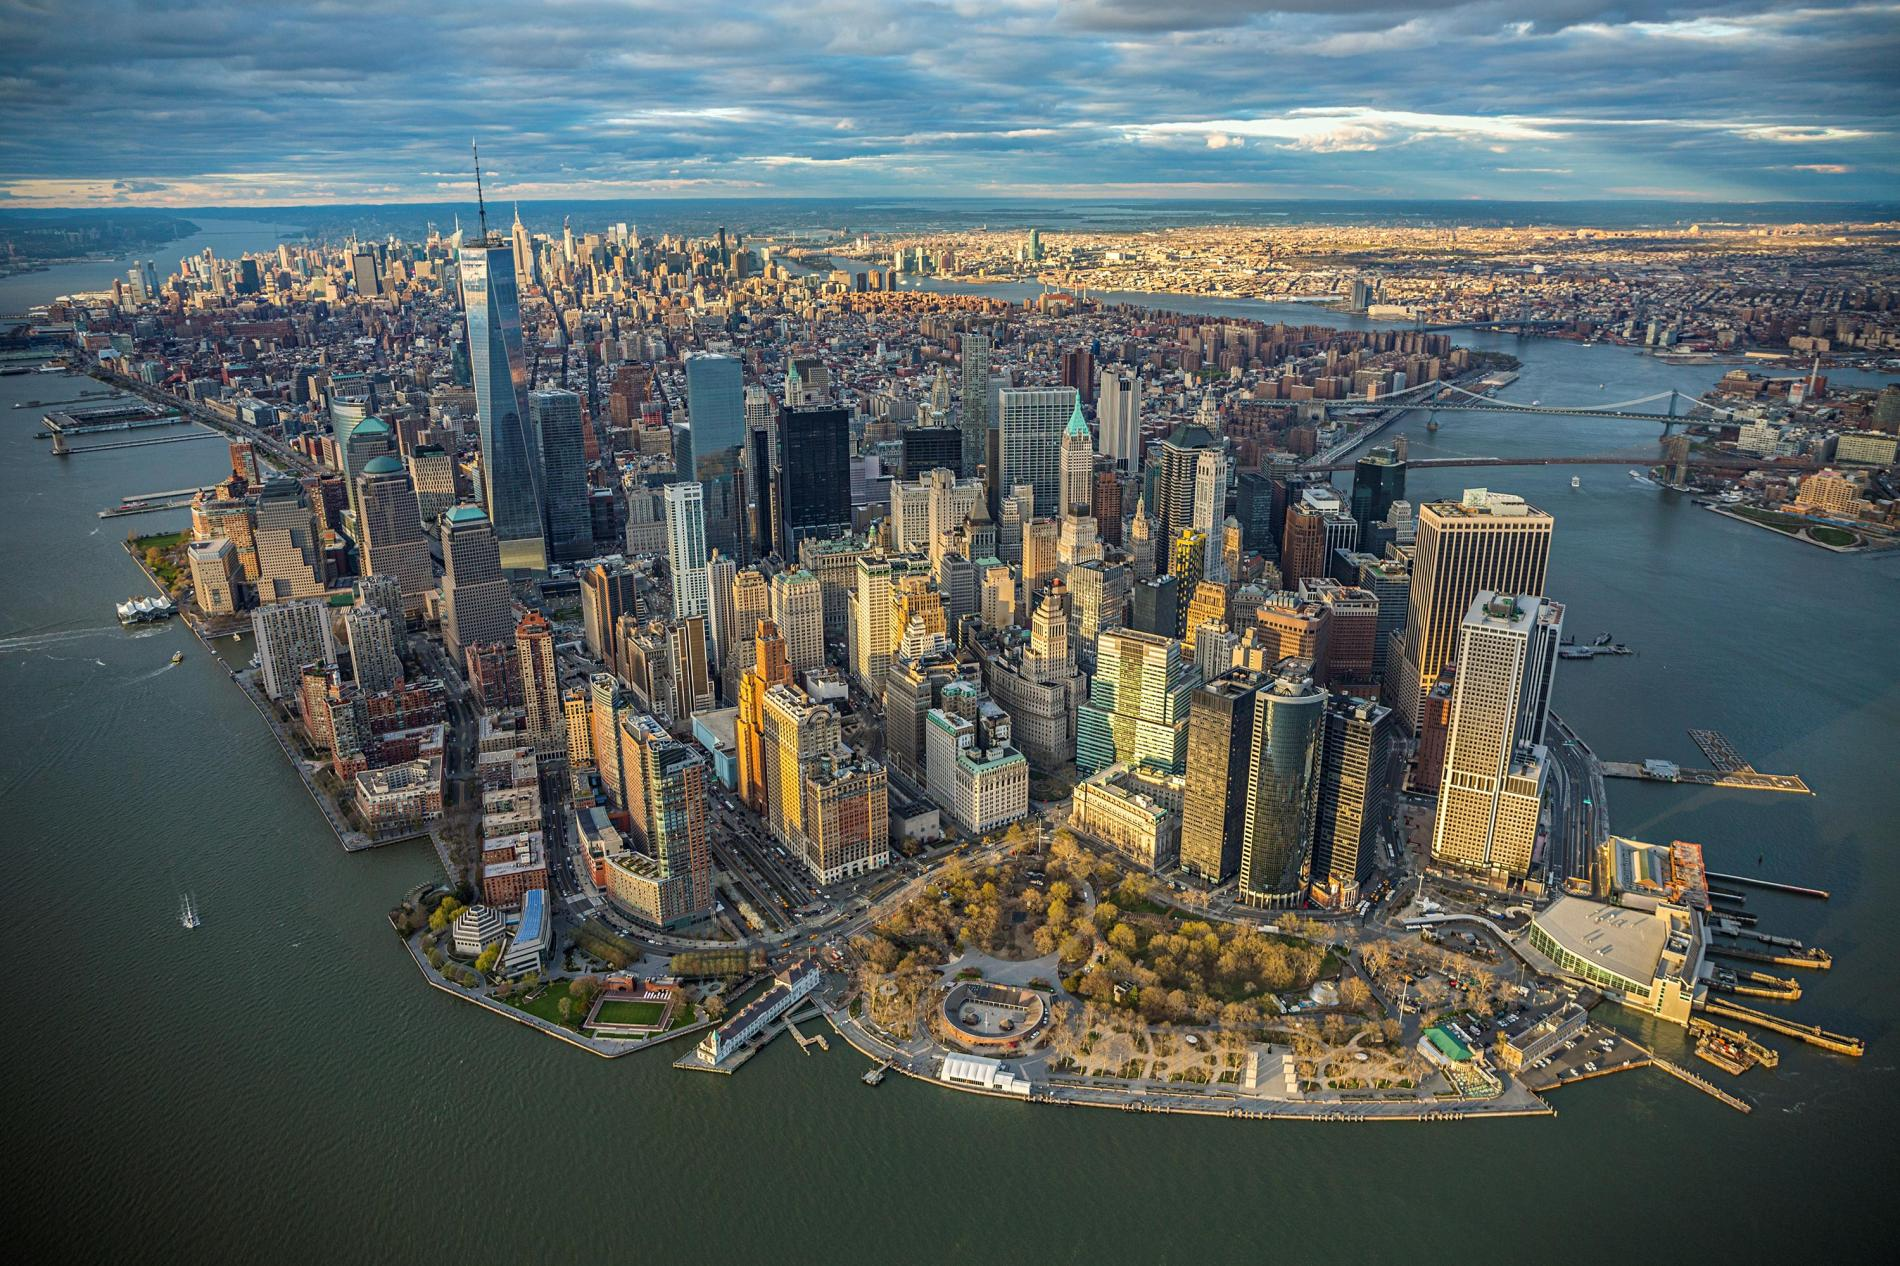

In [420]:
# from PIL import Image
from IPython.display import Image
PATH = "C:/Users/PLV0316/Desktop/"  
Image(filename = PATH + "New-York.jpg", width=1000, height=1000)

# Business Opportunity:
## NYC is one of the most popular city when it comes to traveling. Imagine you are not living in NYC, but sometime in your life, you want to go to a place where everyone knows of. NYC is definitely one of the top choices here. However, it is also known that going/living in NYC can be very expensive, especially if you haven't been in NYC. This project is intented for someone who want to go to some of best places in NYC such as Wall Street etc, but are tight on budget. In that case, I want to provide some recommendations and suggestions for some decent listing choices while keeping a relatively low budget.

# Data:
## Airbnb Data: http://insideairbnb.com/get-the-data.html
## This is the data I would be using. It is the most recent data Airbnb have (compiled on 7/8/2019). For the purpose of this project, I believe this data would be sufficient for ths analysis to provide a real-time recommendation and suggestion. 

# Part 1. Clustering and segmentation of NYC rental units

In [241]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [1]:
import pandas as pd
d_listing = pd.read_csv('listings.csv.gz')

C:\Users\PLV0316\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
d_listing.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 weeks ago,t,30,60,90,365,2019-07-09,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,87%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,"New York, NY, United States",M

In [4]:
d_listing.shape

(48895, 106)

## Who has most listings?

In [40]:
q1=d_listing[['host_id','host_name','host_total_listings_count']].drop_duplicates()

In [41]:
q1.sort_values(by='host_total_listings_count', ascending = False)[:10]

,host_id,host_name,host_total_listings_count
30637,12243051,Sonder,1070.0
9740,30283594,Kara,776.0
42776,24831061,Hosteeva,701.0
26137,107434423,Blueground,687.0
7967,30787515,Brooke,653.0
19150,95459395,Bluebird,528.0
29661,156158778,Sally,473.0
11858,9419684,Mike,441.0
16751,76104209,Rated,435.0
23684,31214940,Scott,363.0


### As you see, most of them are either real estate company and include different kinds of houses such as apartment, entire house. Let's say we are interested in who is renting the most in private room. Assuming we are looking for a private room to stay.

In [15]:
set(d_listing['room_type'])

{'Entire home/apt', 'Private room', 'Shared room'}

In [48]:
q2=d_listing[d_listing['room_type']=='Private room'][['host_id','host_since','host_url','host_name','host_is_superhost','host_total_listings_count']].drop_duplicates().sort_values(by='host_total_listings_count', ascending = False)[:10]
q2

,host_id,host_since,host_url,host_name,host_is_superhost,host_total_listings_count
42776,24831061,2014-12-14,https://www.airbnb.com/users/show/24831061,Hosteeva,f,701.0
41364,219517861,2018-10-08,https://www.airbnb.com/users/show/219517861,Sonder (NYC),f,328.0
27387,109904033,2017-01-04,https://www.airbnb.com/users/show/109904033,Colleen,t,291.0
18905,64065593,2016-03-22,https://www.airbnb.com/users/show/64065593,ResortShare5,f,152.0
39194,9328763,2013-10-09,https://www.airbnb.com/users/show/9328763,Synergy Global,f,146.0
32718,137358866,2017-06-27,https://www.airbnb.com/users/show/137358866,Kazuya,t,115.0
36862,101410003,2016-10-26,https://www.airbnb.com/users/show/101410003,Ricardo,t,113.0
18949,16098958,2014-05-28,https://www.airbnb.com/users/show/16098958,Jeremy & Laura,f,96.0
25242,136676366,2017-06-23,https://www.airbnb.com/users/show/136676366,Karl,t,91.0
7679,24126726,2014-11-24,https://www.airbnb.com/users/show/24126726,Nadine,t,79.0


### Well, some renting facility such as Hosteeva has the most listing count with no surprise. But this guy named Collen has 291 listings since 2017/1/4. My gut tells me this individual must be really good at renting houses on Airbnb. Let's also check their average rating to make sure.

In [64]:
q3= d_listing[d_listing['room_type']=='Private room'][['host_id','host_since','host_url','host_name','host_is_superhost','host_total_listings_count','review_scores_rating']].drop_duplicates().sort_values(by='host_total_listings_count', ascending = False).groupby(['host_id','host_since','host_url','host_name','host_is_superhost','host_total_listings_count']).mean(numeric_only = True).sort_values(by='host_total_listings_count',ascending = False).reset_index()
q3.head(10)

,host_id,host_since,host_url,host_name,host_is_superhost,host_total_listings_count,review_scores_rating
0,24831061,2014-12-14,https://www.airbnb.com/users/show/24831061,Hosteeva,f,701.0,NaN
1,219517861,2018-10-08,https://www.airbnb.com/users/show/219517861,Sonder (NYC),f,328.0,93.000000
2,109904033,2017-01-04,https://www.airbnb.com/users/show/109904033,Colleen,t,291.0,NaN
3,64065593,2016-03-22,https://www.airbnb.com/users/show/64065593,ResortShare5,f,152.0,94.750000
4,9328763,2013-10-09,https://www.airbnb.com/users/show/9328763,Synergy Global,f,146.0,NaN
5,137358866,2017-06-27,https://www.airbnb.com/users/show/137358866,Kazuya,t,115.0,81.666667
6,101410003,2016-10-26,https://www.airbnb.com/users/show/101410003,Ricardo,t,113.0,100.000000
7,16098958,2014-05-28,https://www.airbnb.com/users/show/16098958,Jeremy & Laura,f,96.0,70.000000
8,136676366,2017-06-23,https://www.airbnb.com/users/show/136676366,Karl,t,91.0,NaN
9,24126726,2014-11-24,https://www.airbnb.com/users/show/24126726,Nadine,t,79.0,95.000000


### Somewhat we can see many host, even though they have so many listings, they do not recieve any review at all. I would be cautious about these hosts since it could be that they erase their reviews. Let's then pick the top 5 hosts with rating greater than 95/100.

In [92]:
q4 = q3.dropna()[q3['review_scores_rating']>=95]
q4.head(5)

C:\Users\PLV0316\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,host_id,host_since,host_url,host_name,host_is_superhost,host_total_listings_count,review_scores_rating
6,101410003,2016-10-26,https://www.airbnb.com/users/show/101410003,Ricardo,t,113.0,100.000000
9,24126726,2014-11-24,https://www.airbnb.com/users/show/24126726,Nadine,t,79.0,95.000000
12,31920354,2015-04-25,https://www.airbnb.com/users/show/31920354,Liz,f,56.0,96.500000
22,4440278,2012-12-18,https://www.airbnb.com/users/show/4440278,Emmanuel,f,35.0,95.333333
24,25237492,2014-12-26,https://www.airbnb.com/users/show/25237492,Juliana,t,34.0,100.000000


### Now, we have a group of decent hosts and we want to leverage these hosts to find the top places to stay based on the location and price. 

In [102]:
# filter all data with review score rating greater than 95
df = d_listing[d_listing.host_id.isin(q4.host_id)]
df.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,If this room is unavailable on your desired da...,Very close to F and G trains and Express bus i...,NaN,NaN,-The security and comfort of all our guests is...,NaN,NaN,https://a0.muscache.com/im/pictures/3949d073-a...,NaN,2787,https://www.airbnb.com/users/show/2787,John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/8674565a-7...,https://a0.muscache.com/im/pictures/8674565a-7...,Gravesend,6.0,6.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn , NY, United States",Brooklyn,Kensington,Brooklyn,Brooklyn,NY,11218,New York,"Brooklyn , NY",US,United States,40.64749,-73.97237,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$149.00,$299.00,$999.00,$100.00,$25.00,1,$35.00,1,730,1,1,730,730,1.0,730.0,3 weeks ago,t,30,60,90,365,2019-07-09,9,2,2015-12-04,2018-10-19,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,moderate,f,f,6,0,5,1,0.21
8,5203,https://www.airbnb.com/rooms/5203,20190708031610,2019-07-08,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Stay in my family's little guest room and enj...,"Our best guests are seeking a safe, clean, spa...",none,Our neighborhood is full of restaurants and ca...,"Because we are an active family, I guarantee t...",The number 1 train stops at 110th Street/Cathe...,Guests will be able to come and go as they nee...,My modern family is super busy with lots of co...,"No smoking. In fact, there is no smoking anywh...",NaN,NaN,https://a0.muscache.com/im/pictures/103776/b37...,NaN,7490,https://www.airbnb.com/users/show/7490,MaryEllen,2009-02-05,"New York, New York, United States",Welcome to family life with my oldest two away...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/7490/profile_...,https://a0.muscache.com/im/users/7490/profile_...,Upper West Side,1.0,1.0,"['email', 'phone', 'facebook', 'goog

In [113]:
print('there are {} listings'.format(df.shape[0]))

there are 10878 listings


In [115]:
# select particular columns for clustering
col_name = ['id','host_id','latitude','longitude','accommodates','bathrooms','bedrooms','beds','price','weekly_price','monthly_price',
'square_feet','security_deposit','cleaning_fee','extra_people','number_of_reviews','review_scores_rating','reviews_per_month']
df2 = df[col_name]

In [116]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10878 entries, 0 to 48878
Data columns (total 18 columns):
id                      10878 non-null int64
host_id                 10878 non-null int64
latitude                10878 non-null float64
longitude               10878 non-null float64
accommodates            10878 non-null int64
bathrooms               10869 non-null float64
bedrooms                10878 non-null float64
beds                    10876 non-null float64
price                   10878 non-null object
weekly_price            1343 non-null object
monthly_price           1175 non-null object
square_feet             74 non-null float64
security_deposit        7077 non-null object
cleaning_fee            8713 non-null object
extra_people            10878 non-null object
number_of_reviews       10878 non-null int64
review_scores_rating    10414 non-null float64
reviews_per_month       10443 non-null float64
dtypes: float64(8), int64(4), object(6)
memory usage: 1.6+ MB


In [188]:
# fill na value with -1 for clustering
df3 = df2.fillna(-1)
non_numeric_cols = list(set(df3.columns) - set(df3._get_numeric_data().columns))
df4 = df3[non_numeric_cols]
# remove $ from the fields
df4.security_deposit = df4.security_deposit.apply(lambda x: str(x).strip('$').replace(',',''))
df4.cleaning_fee = df4.cleaning_fee.apply(lambda x: str(x).strip('$').replace(',',''))
df4.price = df4.price.apply(lambda x: str(x).strip('$').replace(',',''))
df4.extra_people = df4.extra_people.apply(lambda x: str(x).strip('$').replace(',',''))
df4.weekly_price = df4.weekly_price.apply(lambda x: str(x).strip('$').replace(',',''))
df4.monthly_price = df4.monthly_price.apply(lambda x: str(x).strip('$').replace(',',''))

In [193]:
# change object to integer/float
df4.security_deposit = df4.security_deposit.astype(float)
df4.cleaning_fee = df4.cleaning_fee.astype(float)
df4.price = df4.price.astype(float)
df4.extra_people = df4.extra_people.astype(float)
df4.weekly_price = df4.weekly_price.astype(float)
df4.monthly_price = df4.monthly_price.astype(float)

In [361]:
# combine numeric and non-numeric columns 
cleaned_df = pd.concat([df3._get_numeric_data(), df4], axis =1)

In [362]:
print(cleaned_df.shape)
cleaned_df.head(2)

(10878, 18)


,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price
0,2539,2787,40.64749,-73.97237,2,1.0,1.0,1.0,-1.0,9,98.0,0.21,100.0,25.0,149.0,35.0,299.0,999.0
8,5203,7490,40.80178,-73.96723,1,1.0,1.0,1.0,-1.0,118,98.0,0.99,-1.0,-1.0,79.0,0.0,-1.0,-1.0


## Clustering and segmenting listings

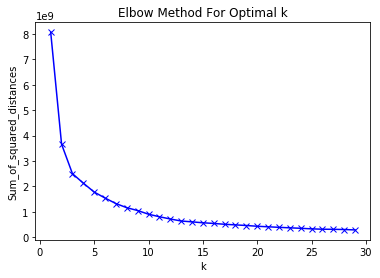

In [363]:
# Selecting best k to cluster based on within-cluster sum of square distance, also known as elbow method
%matplotlib inline  
import matplotlib.pyplot as plt

# exlucded listing id and host id for clustering
c_df = cleaned_df.iloc[:, 2:]

Sum_of_squared_distances = []
K = np.arange(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(c_df)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [364]:
c_df.head(2)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price
0,40.64749,-73.97237,2,1.0,1.0,1.0,-1.0,9,98.0,0.21,100.0,25.0,149.0,35.0,299.0,999.0
8,40.80178,-73.96723,1,1.0,1.0,1.0,-1.0,118,98.0,0.99,-1.0,-1.0,79.0,0.0,-1.0,-1.0


In [365]:
# Based on the graph, let's pick k=5 as our choice
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(c_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 0, 0, 0, 3, 0, 0, 2])

In [366]:
# add label column to the data set
cleaned_df['label'] = kmeans.labels_

In [367]:
cleaned_df.head(2)

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price,label
0,2539,2787,40.64749,-73.97237,2,1.0,1.0,1.0,-1.0,9,98.0,0.21,100.0,25.0,149.0,35.0,299.0,999.0,3
8,5203,7490,40.80178,-73.96723,1,1.0,1.0,1.0,-1.0,118,98.0,0.99,-1.0,-1.0,79.0,0.0,-1.0,-1.0,0


In [368]:
# since 10K would be too much for visulization, we get a random sample of around 1K for visulization
cleaned_df2 = pd.merge(cleaned_df, df[['neighbourhood']], left_index = True, right_index = True, how = 'inner')
X = cleaned_df2.iloc[:,cleaned_df2.columns != 'label']
y = cleaned_df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
sample_df = pd.concat([X_train,y_train], axis=1)
sample_df.head(2)

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price,neighbourhood,label
45079,34516657,141426597,40.85584,-73.93364,2,1.0,1.0,1.0,-1.0,3,100.0,1.61,-1.0,60.0,105.0,0.0,-1.0,-1.0,Manhattan,0
28102,21934181,9175058,40.68782,-73.91890,1,1.0,1.0,1.0,-1.0,17,98.0,0.93,-1.0,15.0,41.0,0.0,-1.0,-1.0,Brooklyn,0


In [369]:
# create map
address = 'NYC'
geolocator = Nominatim(user_agent="NYC_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sample_df['latitude'], sample_df['longitude'], sample_df['neighbourhood'], sample_df['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We can see these lists are spread out everywhere, let's dive deeper to see how they differ.

In [370]:
# check sample and target data label distribution
print(sample_df['label'].value_counts())
print(cleaned_df2['label'].value_counts())

0    975
3     73
4     18
2     18
1      3
Name: label, dtype: int64
0    9556
3     888
2     234
4     157
1      43
Name: label, dtype: int64


In [387]:
cleaned_df2.groupby('label').mean()

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price
label,,,,,,,,,,,,,,,,,,
0,2.078315e+07,6.914482e+07,40.728980,-73.942926,2.108204,1.109774,1.086856,1.229280,1.322415,26.438991,93.507430,1.416675,70.322415,30.134366,93.720385,15.043847,21.743617,-0.351088
1,5.290188e+06,1.578397e+07,40.762173,-73.969361,4.023256,1.116279,1.720930,2.186047,-0.953488,25.046512,94.093023,0.502093,621.023256,101.465116,237.348837,55.883721,1604.488372,6845.186047
2,4.142218e+06,1.051127e+07,40.737154,-73.964417,2.393162,1.108974,1.158120,1.329060,42.346154,64.145299,93.961538,1.059274,267.653846,57.517094,125.461538,25.230769,750.820513,3020.132479
3,4.758852e+06,1.326140e+07,40.725920,-73.945786,1.797297,1.101351,1.040541,1.110360,8.802928,47.778153,96.002252,0.866768,126.685811,31.359234,84.975225,19.481982,410.122748,1462.578829
4,1.882609e+07,5.295622e+07,40.739416,-73.956721,2.656051,1.222930,1.382166,1.560510,15.038217,22.248408,93.178344,1.000255,1602.025478,84.095541,161.566879,30.528662,25.910828,53.464968


### Based on the price, we can see group 1 is the most expensive group and group 0 and 3 are the least expensive group. Keep in mind that weekly, monthly price and review rating have lots of missing values and mean value might not make sense.
### Let's say we are interested in group 3(highest review rating, lowest price, good amount of reviews) . And try to select some listings from there.

In [404]:
group_3 =cleaned_df2[(cleaned_df2.label==3)]
print(group_3.label.value_counts())
group_3.head(2)

3    888
Name: label, dtype: int64


,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price,label,neighbourhood
0,2539,2787,40.64749,-73.97237,2,1.0,1.0,1.0,-1.0,9,98.0,0.21,100.0,25.0,149.0,35.0,299.0,999.0,3,Brooklyn
31,9704,32045,40.81305,-73.95466,2,1.0,1.0,1.0,900.0,88,98.0,1.42,150.0,50.0,52.0,15.0,-1.0,1700.0,3,Harlem


In [408]:
address = 'NYC'
geolocator = Nominatim(user_agent="NYC_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(group_3['latitude'], group_3['longitude'], group_3['neighbourhood'], group_3['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now, we can pick my listings based on our preference of the lcoation. Let's say we want to live in somewhere next to the Wall Street with a very low cost! (How amazing is that!) There are 3 listings I can find on the map, let's dive in those listings.

In [414]:
temp = ['Battery Park City','Financial District']
a = group_3[group_3.neighbourhood.isin(temp)]
b = group_3[(group_3.latitude> 40.70741) & (group_3.latitude< 40.71012) & (group_3.longitude <-74.00102)]
target = pd.concat([a,b], axis = 0)
target

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,number_of_reviews,review_scores_rating,reviews_per_month,security_deposit,cleaning_fee,price,extra_people,weekly_price,monthly_price,label,neighbourhood
735,267376,638721,40.70741,-74.00102,1,1.0,1.0,1.0,-1.0,10,100.0,1.02,800.0,50.0,65.0,0.0,-1.0,1670.0,3,Financial District
1108,470498,2334269,40.71012,-74.01504,2,1.0,1.0,1.0,-1.0,8,100.0,0.13,-1.0,50.0,65.0,15.0,400.0,1550.0,3,Battery Park City
6877,4916150,236659,40.70820,-74.00139,2,1.0,1.0,1.0,-1.0,1,100.0,0.02,200.0,80.0,78.0,0.0,-1.0,1650.0,3,Manhattan


## Now, let's attach the listing urls so that we can book these awesome choices. Enjoy your trip to NYC! (1st link is no longer available)

In [419]:
print(d_listing[d_listing.id.isin(target.id)].listing_url)

735      https://www.airbnb.com/rooms/267376
1108     https://www.airbnb.com/rooms/470498
6877    https://www.airbnb.com/rooms/4916150
Name: listing_url, dtype: object


# Part 2. Topic Modeling using LDA to find listings using users' review.